In [1]:
# 1/25/2022
# markstro

# This notebook demos how PRMS makes the canopy intercepetion calculations

In [2]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import math

In [3]:
pfn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/hru1.params"
outdir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/output/"
indir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/"

In [4]:
# Function that will read PRMS parameter file
# Returns the contents of param file in python data structures
def read_param_file(pfn):
    line_num = 0
    vals = {}
    dims = {}
    param_dims = {}
    param_type = {}

    with open(pfn) as f:
        reading_dims = False
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1
                if line == "** Dimensions **":
                    reading_dims = True
                    line = f.readline().rstrip()
                    line_num += 1

                if line == "** Parameters **":
                    reading_dims = False
                    break

                if reading_dims:
                    line = f.readline().rstrip()
                    line_num += 1
                    dim_name = line

                    line = f.readline().rstrip()
                    line_num += 1
                    size = line

                    if dim_name in dims.keys():
                        pass
                    else:
                        dims[dim_name] = int(size)
            except:
                print("**** read parameters exception line = ", line)
                print("**** read parameters exception line_num = ", str(line_num))
                print("**** Unexpected error:", sys.exc_info()[0])

        #        read params
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1

                if line == "####":
                    line = f.readline().rstrip()
                    line = line.split(" ", 1)[
                        0
                    ]  # old format parameter files have a blank (' ') and then a width format value. Strip this off.
                    param_name = line
                    line_num += 1

                    line = f.readline().rstrip()
                    line_num += 1
                    num_dims = int(line)
                    pd = [None] * num_dims
                    for ii in range(num_dims):
                        line = f.readline().rstrip()
                        pd[ii] = line
                        line_num += 1

                    param_dims[param_name] = pd

                    line = f.readline().rstrip()
                    line_num += 1
                    num_vals = int(line)
                    line = f.readline().rstrip()
                    line_num += 1
                    tp = int(line)
                    param_type[param_name] = tp

                    if tp == 2:
                        vs = np.zeros(num_vals, dtype=np.float)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = float(line)

                    elif tp == 1:
                        vs = np.zeros(num_vals, dtype=np.int)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = int(line)

                    else:
                        vs = np.zeros(num_vals, dtype=np.chararray)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = line

                    if num_dims == 2:
                        vs.shape = (dims[pd[1]], dims[pd[0]])

                    if param_name in vals.keys():
                        print("parameter ", param_name, " is already in ", pfn)
                    else:
                        vals[param_name] = vs

            except:
                print("read parameters exception line_num = ", str(line_num))
                print("Unexpected error:", sys.exc_info()[0])

    gc.collect()

    return (dims, vals, param_dims, param_type)

In [5]:
# I don't understand why I needed to write this function myself
# Input: datetime.Date
# Output: day of the year (aka "Julian date")
def day_of_year(d):
    N1 = math.floor(275 * d.month / 9)
    N2 = math.floor((d.month + 9) / 12)
    N3 = 1 + math.floor((d.year - 4 * math.floor(d.year / 4) + 2) / 3)
    N = N1 - (N2 * N3) + d.day - 30
    return N

# Read the simulated output into a dataframe

In [6]:
# This loops over all of the csv files in the output directory

sim_vals = None
for filename in os.listdir(outdir):
    f = os.path.join(outdir, filename)
    if os.path.isfile(f) and f.endswith(".csv"):
        varname = filename.split(".")[0]

        if sim_vals is None:
            sim_vals = pd.read_csv(f, names=["datestr", varname], skiprows=1)

        else:
            if varname != "stats":
                df = pd.read_csv(f, names=["datestr", varname], skiprows=1)
                sim_vals = pd.merge(
                    sim_vals, df[["datestr", varname]], on="datestr", how="left"
                )

sim_vals["date"] = [
    datetime.strptime(date, "%Y-%m-%d").date() for date in sim_vals["datestr"]
]
del sim_vals["datestr"]

# Read the CBH forcing data into the dataframe

In [7]:
def add_date_for_PRMS_dates(df):
    df["date"] = [date(y, m, d) for y, m, d in zip(df["yr"], df["mo"], df["da"])]
    del df["yr"]
    del df["mo"]
    del df["da"]
    del df["hr"]
    del df["mi"]
    del df["se"]
    return df

In [8]:
# Read the CBH forcing inputs
cbh_vals = None
for filename in os.listdir(indir):
    f = os.path.join(indir, filename)
    if os.path.isfile(f) and f.endswith(".cbh"):
        varname = filename.split(".")[0]

        if cbh_vals is None:
            cbh_vals = pd.read_csv(
                f,
                names=["yr", "mo", "da", "hr", "mi", "se", varname],
                skiprows=3,
                delim_whitespace=True,
            )
            cbh_vals = add_date_for_PRMS_dates(cbh_vals)

        else:
            foo = pd.read_csv(
                f,
                names=["yr", "mo", "da", "hr", "mi", "se", varname],
                skiprows=3,
                delim_whitespace=True,
            )
            foo = add_date_for_PRMS_dates(foo)
            cbh_vals = pd.merge(cbh_vals, foo[["date", varname]], on="date", how="left")

# Sync up the dates of the forcings and the outputs. This makes sure that all values are compared for the same date(s)

In [9]:
synced_vals = pd.merge(cbh_vals, sim_vals, on="date", how="right")

In [10]:
print(synced_vals.shape)

(365, 21)


In [11]:
synced_vals.head()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,...,net_rain,net_snow,pkwater_equiv,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
0,0.00,1980-10-01,77.5,50.1,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.1863,0.0000,403.8735,78.5987,9.8522,49.7339,1
1,0.17,1980-10-02,76.5,51.9,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,...,0.1030,0.0,0.0,0.1840,0.0566,396.4248,77.5987,10.8522,51.5339,1
2,0.43,1980-10-03,65.2,51.5,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,...,0.2629,0.0,0.0,0.1359,0.2017,319.9297,66.2987,10.6300,51.1339,1
3,0.11,1980-10-04,65.2,45.4,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,...,0.0672,0.0,0.0,0.1282,0.2280,316.8498,66.2987,7.2411,45.0339,1
4,0.00,1980-10-05,62.0,43.3,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,...,0.0000,0.0,0.0,0.1083,0.2147,279.8678,63.0987,6.0744,42.9339,1


In [12]:
synced_vals.tail()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,...,net_rain,net_snow,pkwater_equiv,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
360,0.00,1981-09-26,65.1,51.2,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.0559,0.6204,145.3992,66.1987,10.4633,50.8339,1
361,0.02,1981-09-27,76.4,53.0,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,...,0.0113,0.0,0.0,0.1527,0.5382,360.0937,77.4987,11.4633,52.6339,1
362,0.00,1981-09-28,68.1,43.6,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,...,0.0000,0.0,0.0,0.0864,0.5142,233.4196,69.1987,6.2411,43.2339,1
363,0.00,1981-09-29,58.0,40.8,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0,0.0437,0.5026,131.8481,59.0987,4.6855,40.4339,1
364,0.02,1981-09-30,60.7,39.3,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,...,0.0113,0.0,0.0,0.0438,0.4990,130.6410,61.7987,3.8522,38.9339,1


# Compute the canopy storage and net precip

In [13]:
# CONSTANTS

RAIN = 0
SNOW = 1

INACTIVE = 0
LAND = 1
LAKE = 2
SWALE = 3
GLACIER = 4

BARESOIL = 0
GRASSES = 1
SHRUBS = 2
TREES = 3
CONIFEROUS = 4

In [14]:
def subroutine_intercept(precip, stor_max, cov, intcp_stor):
    net_precip = precip * (1.0 - cov)
    intcp_stor = intcp_stor + precip
    if intcp_stor > stor_max:
        net_precip = net_precip + (intcp_stor - stor_max) * cov
        intcp_stor = stor_max

    return intcp_stor, net_precip

In [15]:
def intcp(
    dates,
    transp_on,
    potet,
    hru_snow,
    hru_rain,
    hru_ppt,
    pkwater_equiv,
    covden_sum,
    covden_win,
    hru_type,
    cov_type,
    srain_intcp,
    wrain_intcp,
    potet_sublim,
    epan_coef,
    hru_area,
):
    canopy_covden = np.zeros(len(dates))
    intcp_form = np.zeros(len(dates))
    intcp_stor = np.zeros(len(dates))
    intcp_transp_on = np.zeros(len(dates), dtype=int)
    intcp_evap = np.zeros(len(dates))
    hru_intcpevap = np.zeros(len(dates))
    hru_intcpstor = np.zeros(len(dates))
    net_ppt = np.zeros(len(dates))
    net_rain = np.zeros(len(dates))
    net_snow = np.zeros(len(dates))
    intcp_on = np.zeros(len(dates), dtype=int)
    intcp_changeover = np.zeros(len(dates), dtype=int)

    intcpstor = 0.0
    intcp_transp_on[0] = 1

    ihru = 0

    ii = 0
    for date in dates:
        #     jday = day_of_year(date)
        imon = date.month - 1

        if ii > 0:
            intcpstor = intcp_stor[ii - 1]
            intcp_transp_on[ii] = intcp_transp_on[ii - 1]

        harea = hru_area[ihru]
        netrain = hru_rain[ii]
        netsnow = hru_snow[ii]

        if transp_on[ii] == True:
            canopy_covden[ii] = covden_sum[ihru]
        else:
            canopy_covden[ii] = covden_win[ihru]

        cov = canopy_covden[ii]

        if hru_snow[ii] > 0.0:
            intcp_form[ii] = SNOW
        else:
            intcp_form[ii] = RAIN

        intcpevap = 0.0
        changeover = 0.0
        extra_water = 0.0

        #         print("block 1", transp_on[ii], cov, intcp_form[ii])

        # ! block 2
        if hru_type[ihru] == LAKE or cov_type[ihru] == BARESOIL:
            if cov_type[ihru] == BARESOIL and intcpstor > 0.0:
                extra_water = hru_intcpstor[ii]
            intcpstor = 0.0

        #         print("block 2", hru_type[ihru], cov_type[ihru], extra_water)
        # ! block 3
        #         print("block 3.1", intcpstor)
        if transp_on[ii] is False and intcp_transp_on[ii] is True:
            intcp_transp_on[ii] = False

            #             print("block 3", transp_on[ii], intcp_transp_on[ii])

            # ! block 4
            if intcpstor > 0.0:
                diff = covden_sum[ihru] - cov
                changeover = intcpstor * diff
                if cov > 0.0:
                    if changeover < 0.0:
                        intcpstor = intcpstor * covden_sum[ihru] / cov
                        changeover = 0.0
                # ! block 5

                else:
                    intcpstor = 0

        #             print("block 5", intcpstor, diff, changeover)
        # ! block 6

        elif transp_on[ii] == True and intcp_transp_on[ii] == False:
            #             print("block 6", transp_on[ii], intcp_transp_on[ii], intcpstor)

            # ! block 7

            intcp_transp_on[ii] = True
            if intcpstor > 0.0:
                diff = covden[ii] - cov
                changeover = iontcpstor * diff
                if cov > 0.0:
                    if changeover < 0.0:
                        intcpstor = intcpstor * covden_win[ii] / cov
                        changeover = 0.0

                #                     print("block 7", intcpstor, diff, changeover)
                # ! block 8
                else:
                    intcpstor = 0.0
        # ! block 9

        if hru_type[ihru] != LAKE and cov_type[ihru] != BARESOIL:
            if transp_on[ii] == True:
                stor = srain_intcp[ihru]
            else:
                stor = wrain_intcp[ihru]
            # ! block 10

            #             print("block 10.3", intcpstor)
            if hru_rain[ii] > 0.0:
                if cov > 0.0:
                    if cov_type[ihru] > GRASSES:
                        #                         print("block 10.1", netrain, cov, hru_rain[ii], stor, intcpstor)
                        intcpstor, netrain = subroutine_intercept(
                            hru_rain[ii], stor, cov, intcpstor
                        )
                    #                         print("block 10.2", netrain, cov, hru_rain[ii], stor, intcpstor)
                    elif cov_type[ihru] == GRASSES:
                        # pkwater_equiv in the fortran calculation is from the previous time step because it hasn't been computed yet
                        # for the current time step. The value from the csv file is for the current time step, so lag it back for
                        # consistency
                        if pkwater_equiv[ii - 1] == 0.0 and netsnow == 0.0:
                            intcpstor, netrain = subroutine_intercept(
                                hru_rain[ii], stor, cov, intcpstor
                            )
        #         print("block 10", hru_type[ihru], transp_on[ii], stor, hru_rain[ii], cov , intcpstor,
        #               pkwater_equiv[ii-1], netsnow, netrain)
        # ! block 11

        # ! block 17
        if hru_snow[ii] > 0.0:
            if cov > 0.0:
                if cov_type[ihru] > GRASSES:
                    intcpstor, netsnow = subroutine_intercept(
                        hru_snow[ii], stor, cov, intcpstor
                    )
        #         print("block 17", hru_snow[ii], cov, cov_type[ihru], netsnow, intcpstor, stor)
        # ! block 18

        if intcpstor > 0.0:
            if hru_ppt[ii] == 0.0:
                evrn = potet[ii] / epan_coef[imon]
                evsn = potet_sublim[ihru] * potet[ii]

                #                 print("block 18", intcpstor, hru_ppt[ii], potet[ii], epan_coef[imon], potet_sublim[ihru])

                # ! block 19
                # Compute snow interception loss
                if intcp_form[ii] == SNOW:
                    z = intcpstor - evsn
                    if z > 0.0:
                        intcpstor = z
                        intcpevap = evsn
                    else:
                        intcpevap = intcpstor
                        intcpstor = 0.0

                #                     print("block 19", intcp_form[ii], z, intcpstor, intcpevap)
                # ! block 20

                else:
                    d = intcpstor - evrn
                    if d > 0.0:
                        intcpstor = d
                        intcpevap = evrn
                    else:
                        intcpevap = intcpstor
                        intcpstor = 0.0

        #                     print("block 20", intcp_form[ii], d, intcpstor, intcpevap)
        # ! block 21
        if intcpevap * cov > potet[ii]:
            last = intcpevap
            if cov > 0.0:
                intcpevap = potet[ii] / cov
            else:
                intcpevap = 0.0

            intcpstor = intcpstor + last - intcpevap

        #         print("block 22", intcpevap, cov, potet[ii], intcpstor, intcpevap)

        # ! block 22
        intcp_evap[ii] = intcpevap
        hru_intcpevap[ii] = intcpevap * cov
        intcp_stor[ii] = intcpstor

        if intcpstor > 0.0:
            intcp_on[ii] = 1

        intcp_changeover[ii] = changeover + extra_water
        net_rain[ii] = netrain
        net_snow[ii] = netsnow
        net_ppt[ii] = netrain + netsnow
        #         print("block 23", intcp_evap[ii], hru_intcpevap[ii], intcp_stor[ii], intcp_on[ii], intcp_changeover[ii], net_rain[ii], net_snow[ii], net_ppt[ii])
        # ! block 23
        # ! block 24
        # ! block 25
        ii += 1

    return (
        canopy_covden,
        intcp_form,
        intcp_stor,
        intcp_transp_on,
        net_ppt,
        net_rain,
        net_snow,
        hru_intcpevap,
        hru_intcpstor,
        intcp_evap,
    )

In [16]:
transp_on = synced_vals["transp_on"].values
potet = synced_vals["potet"].values
dates = synced_vals["date"].values
hru_snow = synced_vals["hru_snow"].values
hru_rain = synced_vals["hru_rain"].values
hru_ppt = synced_vals["hru_ppt"].values
pkwater_equiv = synced_vals["pkwater_equiv"].values

params = read_param_file(pfn)
v = params[1]
covden_sum = v["covden_sum"]
covden_win = v["covden_win"]
hru_type = v["hru_type"]
cov_type = v["cov_type"]
srain_intcp = v["srain_intcp"]
wrain_intcp = v["wrain_intcp"]
potet_sublim = v["potet_sublim"]
epan_coef = v["epan_coef"]
hru_area = v["hru_area"]

(
    canopy_covden,
    intcp_form,
    intcp_stor,
    intcp_transp_on,
    net_ppt,
    net_rain,
    net_snow,
    hru_intcpevap,
    hru_intcpstor,
    intcp_evap,
) = intcp(
    dates,
    transp_on,
    potet,
    hru_snow,
    hru_rain,
    hru_ppt,
    pkwater_equiv,
    covden_sum,
    covden_win,
    hru_type,
    cov_type,
    srain_intcp,
    wrain_intcp,
    potet_sublim,
    epan_coef,
    hru_area,
)

In [17]:
dates = synced_vals["date"].values

In [18]:
err = synced_vals["net_ppt"] - net_ppt
print(sum(synced_vals["net_ppt"].values), sum(net_ppt))

41.017299999999985 41.01744262081


In [19]:
ii = 0
for date in dates:
    #     jday = day_of_year(date)
    imon = date.month - 1
    if err[ii] < -0.001:
        print(date, err[ii])
    ii += 1

Text(0, 0.5, 'Error net_ppt (Inches per day)')

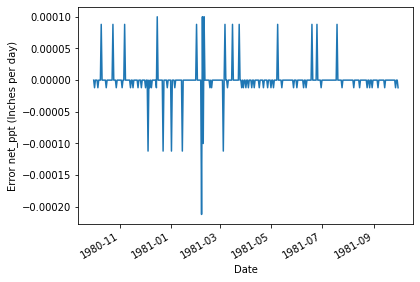

In [20]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("Error net_ppt (Inches per day)")

Text(0, 0.5, 'Python computed net_ppt (Inches per day)')

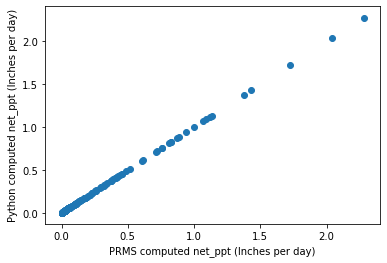

In [21]:
plt.scatter(synced_vals["net_ppt"].values, net_ppt)
plt.xlabel("PRMS computed net_ppt (Inches per day)")
plt.ylabel("Python computed net_ppt (Inches per day)")

In [22]:
err = synced_vals["net_rain"] - net_rain
print(sum(synced_vals["net_rain"].values), sum(net_rain))

40.322299999999984 40.321284390555


Text(0, 0.5, 'Error net_rain (Inches per day)')

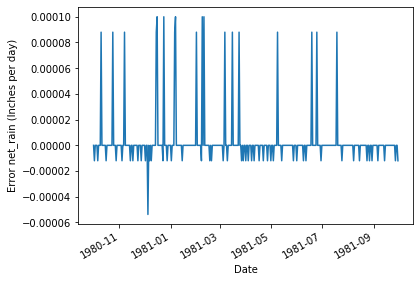

In [23]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("Error net_rain (Inches per day)")

Text(0, 0.5, 'Python computed net_rain (Inches per day)')

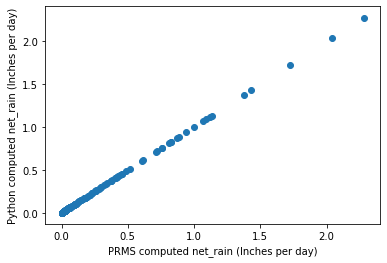

In [24]:
plt.scatter(synced_vals["net_rain"].values, net_rain)
plt.xlabel("PRMS computed net_rain (Inches per day)")
plt.ylabel("Python computed net_rain (Inches per day)")

In [25]:
err = synced_vals["net_snow"] - net_snow
print(sum(synced_vals["net_snow"].values), sum(net_snow))

0.6950000000000001 0.696158230255


Text(0, 0.5, 'Error net_snow (Inches per day)')

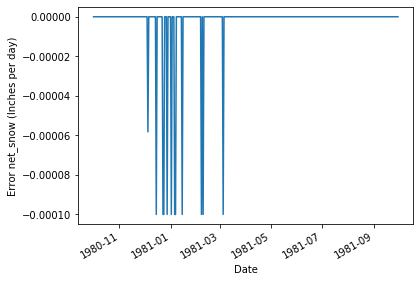

In [26]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("Error net_snow (Inches per day)")

Text(0, 0.5, 'Python computed net_snow (Inches per day)')

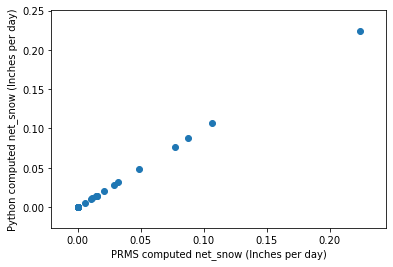

In [27]:
plt.scatter(synced_vals["net_snow"].values, net_snow)
plt.xlabel("PRMS computed net_snow (Inches per day)")
plt.ylabel("Python computed net_snow (Inches per day)")

In [28]:
err = synced_vals["intcp_stor"] - net_snow
print(sum(synced_vals["intcp_stor"].values), sum(intcp_stor))

0.6081000000000023 0.6078260000000003


In [29]:
ii = 0
for date in dates:
    #     jday = day_of_year(date)
    imon = date.month - 1
    if err[ii] < -0.05:
        print(date, err[ii])
    ii += 1

1981-01-02 -0.0834
1981-01-06 -0.0726
1981-01-07 -0.2194
1981-03-05 -0.1026


Text(0, 0.5, 'Error intcp_stor (Inches)')

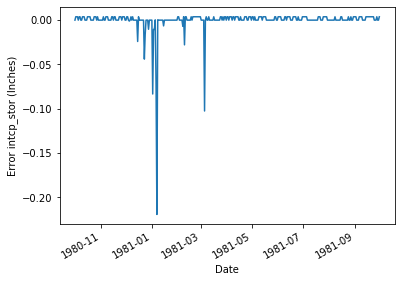

In [30]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("Error intcp_stor (Inches)")

Text(0, 0.5, 'Python computed intcp_stor (Inches)')

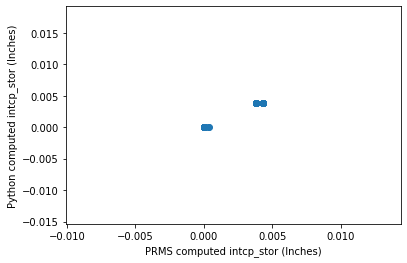

In [31]:
plt.scatter(synced_vals["intcp_stor"].values, intcp_stor)
plt.xlabel("PRMS computed intcp_stor (Inches)")
plt.ylabel("Python computed intcp_stor (Inches)")

In [32]:
err = synced_vals["intcp_evap"] - net_snow
print(sum(synced_vals["intcp_evap"].values), sum(intcp_evap))

0.2349999999999999 0.23466699999999976


Text(0, 0.5, 'Error intcp_evap (Inches)')

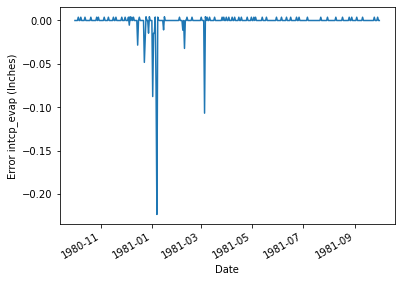

In [33]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("Error intcp_evap (Inches)")

Text(0, 0.5, 'Python computed intcp_evap (Inches)')

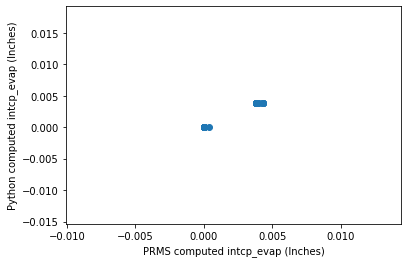

In [34]:
plt.scatter(synced_vals["intcp_evap"].values, intcp_evap)
plt.xlabel("PRMS computed intcp_evap (Inches)")
plt.ylabel("Python computed intcp_evap (Inches)")

Text(0, 0.5, 'running wb (Inches)')

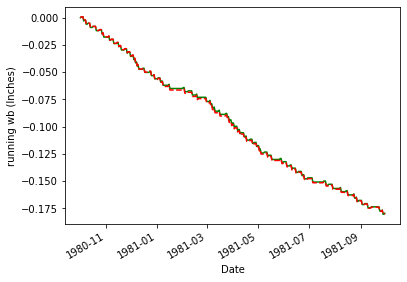

In [35]:
s1 = np.zeros(len(dates))
s2 = np.zeros(len(dates))
s1[0] = 0
s2[0] = 0
for ii in range(1, len(dates)):
    s1[ii] = s1[ii - 1] + hru_ppt[ii] - net_ppt[ii] - intcp_evap[ii]
    s2[ii] = (
        s2[ii - 1]
        + synced_vals["hru_ppt"].values[ii]
        - synced_vals["net_ppt"].values[ii]
        - synced_vals["intcp_evap"].values[ii]
    )
    ii += 1


plt.plot(dates, s1, c="green")
plt.plot(dates, s2, linestyle="dashed", c="red")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Date")
plt.ylabel("running wb (Inches)")